### Importing packages and data_utils.py

In [1]:
from data_utils import *

2023-06-12 01:01:28.817514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 01:01:29.734839: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!pwd

/ocean/projects/atm200007p/jlin96


### Initialize folder paths

In [3]:
data_path = '/ocean/projects/atm200007p/walrus/for_jerry/train/'
norm_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/mooers_metrics/norm_factors/'
grid_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/mooers_metrics/test_data/E3SM-MMF_ne4_grid-info.orig.nc'
target_scoring_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/val_target_stride6.npy'
cvae_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/cVAE/cvae_preds_bestcrps.h5'
hsr_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/HSR/hsr_preds_bestcrps.h5'
rpn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/rpn_pred_v1_stride6.npy'
cnn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/val_predict_cnn_reshaped_stride6_FINAL.npy'
mlp_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy'

### Create variables necessary for initialization

In [4]:
data_path = data_path
input_vars = ['state_t','state_q0001','state_ps','pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX']
target_vars = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']
grid_info = xr.open_dataset(grid_path)
inp_mean = xr.open_dataset(norm_path + 'mli_mean.nc')
inp_max = xr.open_dataset(norm_path + 'mli_max.nc')
inp_min = xr.open_dataset(norm_path + 'mli_min.nc')
out_scale = xr.open_dataset(norm_path + 'mlo_scale.nc')

### Create data_utils object

In [5]:
example_data = data_utils(data_path = data_path, 
                          input_vars = input_vars, 
                          target_vars = target_vars, 
                          grid_info = grid_info, 
                          inp_mean = inp_mean, 
                          inp_max = inp_max, 
                          inp_min = inp_min, 
                          out_scale = out_scale)

### Create pressure grid and set values for attributes

In [6]:
# set regular expressions for selecting data
example_data.set_regexps(data_split = 'scoring', regexps = ['E3SM-MMF.mli.0008-0[23456789]-*-*.nc',
                                                          'E3SM-MMF.mli.0008-1[012]-*-*.nc',
                                                          'E3SM-MMF.mli.0009-01-*-*.nc'])
# set temporal subsampling
example_data.set_stride_sample(data_split = 'scoring', stride_sample = 6)
# create list of files to extract data from
example_data.set_filelist(data_split = 'scoring')
# create pressure grid
pressure_grid = example_data.get_pressure_grid(data_split = 'scoring')
# load reference output
example_data.ref_scoring = np.load(target_scoring_path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4380/4380 [00:31<00:00, 141.27it/s]


### Load predictions from each model

In [7]:
example_data.model_names = ['cVAE','HSR','RPN','CNN', 'MLP']
example_data.preds_scoring = [example_data.get_pred_h5(load_path = cvae_pred_path), 
                              example_data.get_pred_h5(load_path = hsr_pred_path),
                              example_data.get_pred_npy(load_path = rpn_pred_path), 
                              example_data.get_pred_npy(load_path = cnn_pred_path),
                              example_data.get_pred_npy(load_path = mlp_pred_path)]

### Plot pressure latitude R2 analysis

/ocean/projects/atm200007p/jlin96/data_utils.py:367: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  contour_plot = ax[0,i].pcolor(X, Y, coeff,cmap='Blues', vmin = 0, vmax = 1) # pcolormesh
/ocean/projects/atm200007p/jlin96/data_utils.py:374: RuntimeWarning: divide by zero encountered in divide
  coeff = 1 - np.sum( (pred_moist_daily_long-test_moist_daily_long)**2, axis=1)/np.sum( (test_moist_daily_long-np.mean(test_moist_daily_long, axis=1)[:,None,:])**2, axis=1)
/ocean/projects/atm200007p/jlin96/data_utils.py:378: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  contour_plot = ax[1,i].pcolor(X, Y, co

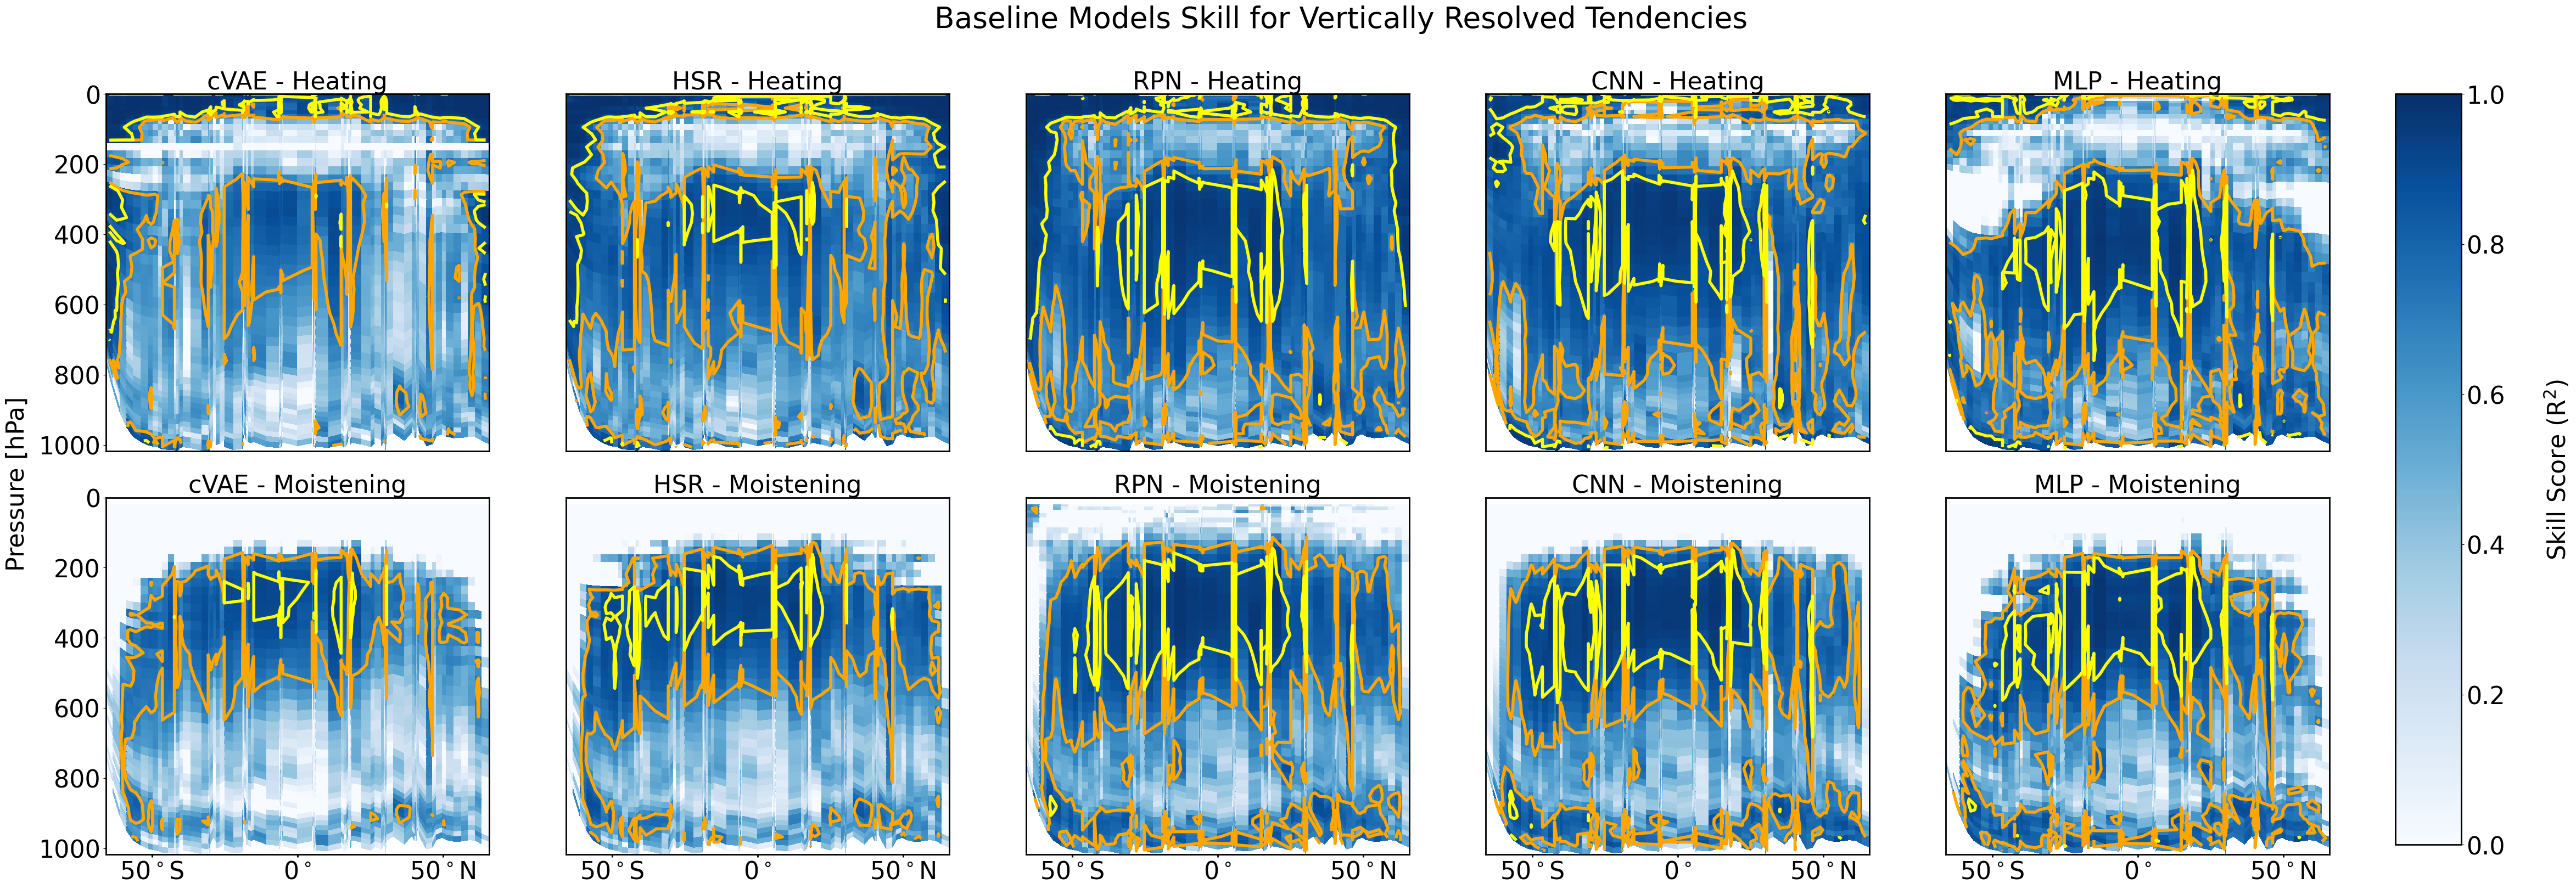

<Figure size 640x480 with 0 Axes>

In [8]:
example_data.set_plot_params()
%config InlineBackend.figure_format = 'retina'
example_data.plot_r2_analysis(pressure_grid = pressure_grid)